# はじめに
ニューラルネットワークの予測の不確実性を算出する手法を検証します。

### 概要
- 連続値を予測する回帰のためのニューラルネットワークを構築
- Stochastic gradient Langevin dynamics (SGLD) で予測の不確実性を算出


# Stochastic gradient Langevin dynamics  
確率的勾配降下法とランジュバン動力学によるを組み合わせて、パラメータの事後分布をサンプリングする手法です。  
SGLDの更新式に従ってパラメータを更新し、その過程のパラメータを事後分布からのサンプリングとして近似的に使用します。

バッチサイズを$b$、データセットのサイズを$n$、パラメータの更新量は下記になります。  
$$
\Delta \theta = \frac{\alpha}{2}\Bigl(\frac{n}{b}\sum_i \nabla \log p(y_i|x_i,\theta) + \nabla \log p(\theta)\Bigr) + \sqrt{\alpha} \mathcal{N}(0,\rm{I})
$$
ここで、$\alpha$はSGLDのパラメータです。  
上式は確率的勾配降下法によるパラメータの更新に正規分布に従うノイズを付加した形になっています。  

パラメータ$\theta$でのデータ$x$の予測を$p(y|x,\theta)=\mathcal{N}(f(x;\theta),\sigma^2)$、正解を$y$とすると、$\log p(y|x,\theta)=-\frac{\log 2\pi\sigma^2}{2} - \frac{(y-f(x;\theta))^2}{2\sigma^2}$となります。  
つまり、この場合2乗誤差を最小化すればよいことになります。  
また、$p(\theta)$に関しても平均0の正規分布を仮定すれば、パラメータのL2ノルムを最小化すればよいことになります。  

### DP-SGDとの関係  
SGLDの更新式は、差分プライバシーを保証した確率的勾配法（DP-SGD）と等価であることが知られています。  
DP-SGDの更新式は下記で定義されます。
$$
\Delta \theta = \eta \biggl( \frac{1}{b} \sum_{i} {\rm clip}_C (\nabla \log p(y_i|x_i, \theta)) + \frac{1}{n}\nabla_{\theta} \log p(\theta) + \mathcal{N}(0,\sigma^2c^2\rm{I}) \biggr)
$$
ここで、${\rm clip}_C$はベクトルのL2ノルムを最大$C$に制限する関数、$\eta$は学習率、$c$と$\sigma$はDP-SGDのパラメータです。
DP-SGDのパラメータが$C=\frac{b\sqrt{2}}{\sigma \sqrt{\eta n}}$を満たす際に、SGLDと等価になります。  


### 不確実性の算出  
推論結果の事後分布は、パラメータの分布$p(\theta)$を考え、積分で$\theta$を消去することで求めます。  
$$
p(y|x) = \int p(y|x, \theta)p(\theta) {\rm d}\theta
$$
この積分をSGLDでパラメータをサンプリングした結果$\{\theta_1, \cdots, \theta_n\}$を用いて近似します。  

事後分布の期待値と分散は下記の通り求めることができます。  
$$
\mu(y) = \frac{1}{n}\sum_{i=1}^n f(x;\theta_i)
$$
$$
{\rm Var}(y) = \sigma^2 + \frac{1}{n}\sum_{i=1}^n f(x;\theta_i)^T f(x;\theta_i) - \mu(y)^T \mu(y)
$$



# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。

In [2]:
import sys
import os
import copy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install 'opacus>=1.0'
import opacus

import warnings
warnings.simplefilter("ignore")

### 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  
[Google Colaboratory](https://colab.research.google.com/?hl=ja)で実行した際の例になります。

In [3]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
print('Opacus:', opacus.__version__)
!nvidia-smi

Python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
PyTorch: 2.0.1+cu118
Opacus: 1.4.0
Sat Sep 23 01:22:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------------------

### 3. データセットの作成  
sinカーブに従うデータを作成します。  
ただし、学習には[-1,1]の範囲のデータは使用しません。


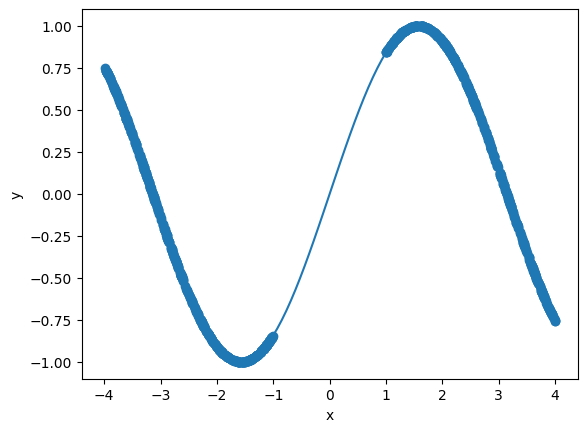

In [4]:
def make_dataset(seed, plot=0, batch_size=64):
    np.random.seed(seed)

    x_true = np.linspace(-4, 4, 100)
    y_true = np.sin(x_true)

    x = np.concatenate([np.random.uniform(-4, -1, 500), np.random.uniform(1, 4, 500)])
    y = np.sin(x)

    # データをPyTorchのテンソルに変換
    x = torch.from_numpy(x).float().view(-1, 1)
    y = torch.from_numpy(y).float().view(-1, 1)
    x_true = torch.from_numpy(x_true).float().view(-1, 1)

    # グラフを描画
    if plot == 1:
        plt.plot(x_true, y_true)
        plt.scatter(x, y)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

    dataset = torch.utils.data.TensorDataset(x, y)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader

_ = make_dataset(0, plot=1)

### 4. ニューラルネットワークの定義  
今回は3層の全結合ニューラルネットワークを用います。

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### 5. 学習
SGLDの実装としては、opacusのDP-SGDの実装を利用します。

In [6]:

lr = 1e-2
batch_size = 16
sigma = 1.0
n_data = 1000
c = batch_size/sigma*np.sqrt(2/lr/n_data)
print('sigma:', sigma, 'c:', c)


device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

data_loader = make_dataset(0, batch_size=batch_size)
model = Net()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)


privacy_engine = opacus.PrivacyEngine()
model, optimizer, data_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=data_loader,
    noise_multiplier=sigma,
    max_grad_norm=c,
)


# 学習
model.train()
num_epochs = 100
loss_list = []
model_list = []
for epoch in range(num_epochs):
    tmp_loss = []
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # 順伝播と損失の計算
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        loss = loss.mean()
        tmp_loss.append(loss.item())
        # 勾配の初期化と逆伝播
        optimizer.zero_grad()
        loss.backward()

        # パラメータの更新
        optimizer.step()
    tmp = copy.deepcopy(model)
    model_list.append(tmp)

epsilon = privacy_engine.get_epsilon(1e-5)
print('epsilon', epsilon)


sigma: 1.0 c: 7.155417527999327
epsilon 8.18112861247535


### 6. 予測
予測の事後分布の平均、標準偏差を描画します。

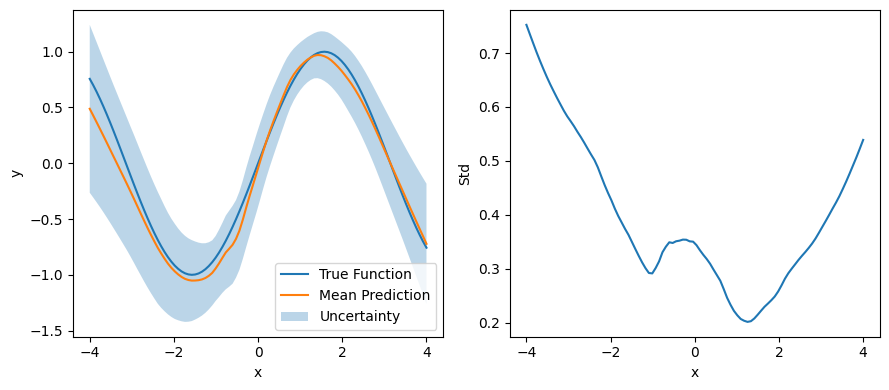

In [7]:
x_true = np.linspace(-4, 4, 100)
y_true = np.sin(x_true)
x_true = torch.from_numpy(x_true).float().view(-1, 1)

plt.figure(figsize=(9,4))
y_preds = []
for model in model_list:
    model.eval()
    x_true = x_true.to(device)
    with torch.no_grad():
        y_pred = model(x_true)
    y_preds.append(y_pred.to('cpu').detach().numpy())
y_mean = np.mean(y_preds, axis=0)
y_std = np.sqrt(np.var(y_preds, axis=0) + 1e-4)
x_true = x_true.to('cpu')

plt.subplot(121)
plt.plot(x_true, y_true, label='True Function')
plt.plot(x_true, y_mean, label='Mean Prediction')
plt.fill_between(x_true.flatten(), y_mean.flatten() - y_std.flatten(), y_mean.flatten() + y_std.flatten(), alpha=0.3, label='Uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(122)
plt.plot(x_true, y_std)
plt.xlabel('x')
plt.ylabel('Std')

plt.tight_layout()
plt.show()

# おわりに

### 今回の結果
予測の不確実性は、x最小値および最大値付近とデータが含まれない[-1,1]の範囲で大きくなっています。  
データ数が少なく、予測が不確実と考えられる領域と、予測の標準偏差が大きい領域が一致しているため、想定通り予測の不確実性が算出できていると考えられます。  
ただし、stochastic variational inferenceやMC dropoutと比較して、多くの教師データが必要となります。

### 次にやること
予測の不確実性を算出する他の手法も検証したいと思います。  

### 参考資料
- M. Welling and Y. W. Teh, Bayesian learning via stochastic gradient
Langevin dynamics, ICML, 2011.
- M. Abadi, et al., Deep learning with differential privacy, ACM CCS, 2016.
- B. Li, et al., On connecting stochastic gradient MCMC and differential privacy, AISTATS, 2019.



